# Определение перспективного тарифа для телеком компании

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Изучение данных из файлов

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import math
from functools import reduce

Загрузим данные из разных файлов.

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

Изучим по отдельности каждый файл.

Таблица users (информация о пользователях):
- user_id — уникальный идентификатор пользователя;
- first_name — имя пользователя;
- last_name — фамилия пользователя;
- age — возраст пользователя (годы);
- reg_date — дата подключения тарифа (день, месяц, год);
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных);
- city — город проживания пользователя;
- tariff — название тарифного плана.

In [3]:
display(users.sample(10, random_state=1))

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
304,1304,68,NaN,Владимир,Илья,Соловьёв,2018-11-05,ultra
340,1340,50,NaN,Пенза,Тимофей,Алютин,2018-01-30,smart
47,1047,67,NaN,Саратов,Милица,Меркулова,2018-10-29,smart
67,1067,45,NaN,Москва,Юзефа,Абашкина,2018-04-09,smart
479,1479,40,NaN,Хабаровск,Игорь,Богданов,2018-07-03,smart
485,1485,34,NaN,Киров,Таисия,Сухова,2018-12-29,ultra
310,1310,28,NaN,Уфа,Рудольф,Нестеров,2018-03-22,ultra
31,1031,66,NaN,Москва,Лаврентий,Тимофеев,2018-11-02,smart
249,1249,25,NaN,Курск,Изольда,Авдушева,2018-08-14,smart
90,1090,54,2018-12-03,Череповец,Екатерина,Астафьева,2018-10-11,ultra


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Есть пропущенные значения в столбце 'churn_date'. Из 500 строк заполнено только 38, это значит, что на момент выгрузки данных клиенты перестали пользоваться тарифом. Заполнять пропуски не будем.

Таблица calls (информация о звонках):
- id — уникальный номер звонка;
- call_date — дата звонка;
- duration — длительность звонка в минутах;
- user_id — идентификатор пользователя, сделавшего звонок.

In [5]:
display(calls.sample(10, random_state=1))

,id,call_date,duration,user_id
26953,1066_374,2018-08-26,0.00,1066
66122,1168_1273,2018-03-28,16.05,1168
67325,1171_350,2018-09-14,6.23,1171
74643,1186_465,2018-09-02,0.79,1186
192311,1472_124,2018-05-04,5.94,1472
47375,1118_664,2018-10-24,13.41,1118
91143,1227_563,2018-08-03,15.15,1227
3818,1010_67,2018-08-16,14.29,1010
182822,1454_574,2018-09-23,9.98,1454
187346,1463_0,2018-12-05,10.63,1463


In [6]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Пропущенных значений нет, но есть значения = 0.00. Скорее всего, это пропущенные вызовы, заменять такие данные не будем, т.к. они не влияют на расчёты.

Таблица messages (информация о сообщениях):
- id — уникальный номер сообщения;
- message_date — дата сообщения;
- user_id — идентификатор пользователя, отправившего сообщение.

In [7]:
display(messages.sample(10, random_state=1))

,id,message_date,user_id
45696,1197_26,2018-12-31,1197
66091,1282_523,2018-11-30,1282
18743,1082_184,2018-10-18,1082
33759,1146_557,2018-12-22,1146
11403,1048_49,2018-09-27,1048
97793,1401_125,2018-08-10,1401
406,1000_406,2018-12-29,1000
71393,1302_221,2018-10-23,1302
103004,1420_11,2018-12-12,1420
53795,1238_208,2018-10-08,1238


In [8]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Пропущенных значений нет.

Таблица internet (информация об интернет-сессиях):
- id — уникальный номер сессии;
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах);
- session_date — дата интернет-сессии;
- user_id — идентификатор пользователя.

In [9]:
display(internet.sample(10, random_state=1))

,Unnamed: 0,id,mb_used,session_date,user_id
35745,35745,1124_125,122.45,2018-12-03,1124
18383,18383,1064_102,320.60,2018-12-19,1064
59774,59774,1203_22,605.96,2018-06-17,1203
56317,56317,1188_123,781.73,2018-05-08,1188
52231,52231,1176_386,150.98,2018-08-20,1176
20276,20276,1068_26,389.65,2018-12-04,1068
82748,82748,1281_64,841.89,2018-11-07,1281
129266,129266,1431_300,461.23,2018-11-26,1431
46783,46783,1160_75,0.00,2018-08-15,1160
48492,48492,1168_260,336.06,2018-07-28,1168


In [10]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


Таблица tariffs (информация о тарифах):
- tariff_name — название тарифа;
- rub_monthly_fee — ежемесячная абонентская плата в рублях;
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату;
- messages_included — количество сообщений в месяц, включённых в абонентскую плату;
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах);
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата);
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета;
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта).

In [11]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Данные о тарифах не содержат пропусков или некорректных значений.

### Вывод

При изучении файлов были выявлены следующие пункты:
- пропуски в столбце 'churn_date', но они не влияют на анализ данных, поэтому из заполнять не нужно;
- в столбце 'duration' есть значения = 0.00, которые мы заменять не будем, т.к. это могут быть пропущенные звонки, которые не влияют на расходы клиентов;
- в столбце 'mb_used' есть значения = 0.00, которые мы заменять не будем, т.к. это не тарифицируемые значения;
- значения в столбцах 'duration' и 'mb_used', кроме 0, необходимо округлить вверх до целого значения;
- в столбцах с датами необходимо изменить тип данных.

## Предобработка данных

Изменим тип данных в столбцах 'reg_date', 'churn_date', 'call_date', 'message_date' и 'session_date' - из строки в дату. Это необходимо сделать, чтобы получить месяц.

In [12]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

«Мегалайн» всегда округляет вверх значения минут и мегабайтов, поэтому необходимо округлить значения минут и мегабайтов с помощью np.ceil.

In [13]:
calls['duration'] = calls['duration'].apply(np.ceil)
internet['mb_used'] = internet['mb_used'].apply(np.ceil)

Посчитаем для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя.

Для начала добавим новые столбцы с месяцами.

In [14]:
calls['month'] = calls['call_date'].dt.month
messages['month'] = messages['message_date'].dt.month
internet['month'] = internet['session_date'].dt.month

Сгруппируем данные по каждой таблице.

In [15]:
calls_data = calls.groupby(['user_id', 'month'])[['duration']].agg(['count', 'sum'])
calls_data.columns = ['calls_qty', 'calls_duration']
calls_data

calls_qty  calls_duration
user_id month                           
1000    5             22           159.0
        6             43           172.0
        7             47           340.0
        8             52           408.0
        9             58           466.0
...                  ...             ...
1498    10            41           247.0
1499    9              9            70.0
        10            68           449.0
        11            74           612.0
        12            69           492.0

[3174 rows x 2 columns]

In [16]:
messages_data = messages.groupby(['user_id', 'month'])[['user_id']].agg(['count'])
messages_data.columns = ['messages_qty']
messages_data

messages_qty
user_id month              
1000    5                22
        6                60
        7                75
        8                81
        9                57
...                     ...
1498    10               42
1499    9                11
        10               48
        11               59
        12               66

[2717 rows x 1 columns]

In [17]:
internet_data = internet.groupby(['user_id', 'month'])[['mb_used']].agg(['sum'])
internet_data.columns = ['mb_used']
internet_data

mb_used
user_id month         
1000    5       2256.0
        6      23257.0
        7      14016.0
        8      14070.0
        9      14581.0
...                ...
1498    10     20604.0
1499    9       1848.0
        10     17809.0
        11     17984.0
        12     13077.0

[3203 rows x 1 columns]

Объединим три таблицы в одну.

In [18]:
dfs = [calls_data, messages_data, internet_data]
total_data = reduce(lambda left,right: pd.merge(left,right,on=['user_id', 'month'], how='outer'), dfs)
total_data.head(10)

calls_qty  calls_duration  messages_qty  mb_used
user_id month                                                  
1000    5           22.0           159.0          22.0   2256.0
        6           43.0           172.0          60.0  23257.0
        7           47.0           340.0          75.0  14016.0
        8           52.0           408.0          81.0  14070.0
        9           58.0           466.0          57.0  14581.0
        10          57.0           350.0          73.0  14717.0
        11          43.0           338.0          58.0  14768.0
        12          46.0           333.0          70.0   9827.0
1001    11          59.0           430.0           NaN  18452.0
        12          63.0           414.0           NaN  14053.0

В объединной таблице встречаются пропущенные значения - это значит, что абонент в этот месяц не совершал каких-то операций, например, не отправлял сообщения.
Проверим, в каких столбцах есть пропущенные значения.

In [19]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3214 entries, (1000, 5) to (1476, 4)
Data columns (total 4 columns):
calls_qty         3174 non-null float64
calls_duration    3174 non-null float64
messages_qty      2717 non-null float64
mb_used           3203 non-null float64
dtypes: float64(4)
memory usage: 113.9 KB


Пропущенные значения есть во всех столбцах, поэтому их нужно заменить на 0. Также изменим тип даных на целочисленный, т.к. все значения округлены вверх до целого.

In [20]:
total_data = total_data.fillna(0).astype('int') 

Проверим, правильно ли объединились таблицы и все ли значения попали в новую таблицу.
Сравним суммарные значения столбцов из новой таблицы со значениями столбцов из отдельных таблиц.

In [21]:
if calls['duration'].count() == total_data['calls_qty'].sum():
    print('Количество звонков совпадает.')
else:
    print('Количество звонков не совпадает. Нужно найти ошибку.')

if calls['duration'].sum() == total_data['calls_duration'].sum():
    print('Продолжительность звонков совпадает.')
else:
    print('Продолжительность звонков не совпадает. Нужно найти ошибку.')

if messages['user_id'].count() == total_data['messages_qty'].sum():
    print('Количество сообщений совпадает.')
else:
    print('Количество сообщений не совпадает. Нужно найти ошибку.')
    
if internet['mb_used'].sum() == total_data['mb_used'].sum():
    print('Количество интернет-трафика совпадает.')
else:
    print('Количество интернет-трафика не совпадает. Нужно найти ошибку.')

Количество звонков совпадает.
Продолжительность звонков совпадает.
Количество сообщений совпадает.
Количество интернет-трафика совпадает.


Всё совпадает, а это значит, что все данные есть в новой таблице.

Создадим новые столбцы:
- 'tariff' - название тарифа, которым пользуется клиент;
- 'city' - город проживания клиента;
- 'monthly_revenue' - ежемесячная выручка.

In [22]:
for user_id in total_data.index:
    total_data.loc[user_id, 'tariff'] = users.loc[user_id[0]-1000, 'tariff']

In [23]:
total_data = total_data.join(users.loc[:,['user_id', 'city']].set_index('user_id'), how='outer')

In [24]:
# функция подсчета выручки с каждого пользователя в месяц
def revenue(row):
    duration = row['calls_duration']
    messages = row['messages_qty']
    mb_used = row['mb_used']
    tariff = row['tariff']      
   
    if tariff == 'smart':
        extra_duration = duration - tariffs.loc[0, 'minutes_included']
        extra_messages = messages - tariffs.loc[0, 'messages_included']
        extra_gb = math.ceil((mb_used - tariffs.loc[0, 'mb_per_month_included']) / 1024)
                
        if extra_duration < 0: 
            extra_duration = 0        
        if extra_messages < 0: 
            extra_messages = 0
        if extra_gb < 0: 
            extra_gb = 0
        
        return (tariffs.loc[0, 'rub_per_minute'] * extra_duration + 
                   tariffs.loc[0, 'rub_per_message'] * extra_messages +
                   tariffs.loc[0, 'rub_per_gb'] * extra_gb + 
                   tariffs.loc[0, 'rub_monthly_fee']
                  ) 
    else:
        extra_duration = duration - tariffs.loc[1, 'minutes_included']
        extra_messages = messages - tariffs.loc[1, 'messages_included']
        extra_gb = math.ceil((mb_used - tariffs.loc[1, 'mb_per_month_included']) / 1024)
        
        
        if extra_duration < 0: 
            extra_duration = 0
        if extra_gb < 0: 
            extra_gb = 0
        if extra_messages < 0: 
            extra_messages = 0
        
        return (tariffs.loc[1, 'rub_per_minute'] * extra_duration +             
                   tariffs.loc[1, 'rub_per_message'] * extra_messages + 
                   tariffs.loc[1, 'rub_per_gb'] * extra_gb + 
                   tariffs.loc[1, 'rub_monthly_fee']
                  )

total_data['monthly_revenue'] = total_data.apply(revenue, axis=1)
total_data.head(10)

calls_qty  calls_duration  messages_qty  mb_used tariff  \
user_id month                                                            
1000    5             22             159            22     2256  ultra   
        6             43             172            60    23257  ultra   
        7             47             340            75    14016  ultra   
        8             52             408            81    14070  ultra   
        9             58             466            57    14581  ultra   
        10            57             350            73    14717  ultra   
        11            43             338            58    14768  ultra   
        12            46             333            70     9827  ultra   
1001    11            59             430             0    18452  smart   
        12            63             414             0    14053  smart   

                    city  monthly_revenue  
user_id month                              
1000    5      Краснодар             1950  
        6      Краснодар             1950  
        7      Краснодар             1950  
        8      Краснодар             1950  
        9      Краснодар             1950  
        10     Краснодар             1950  
        11     Краснодар             1950  
        12     Краснодар             1950  
1001    11        Москва             1350  
        12        Москва              550

In [25]:
total_data['monthly_revenue'].sum()

4925751

Мы получили необходимые данные для их дальнейшего анализа.

### Вывод

В ходе данного этапа были сделаны следующие шаги и выводы:
- изменён тип данных в столбцах с датами, чтобы можно было выделить месяц;
- значения в столбцах с минутами и мегабайтами округлили вверх до ближайшего целого числа (это связано с условиями тарификации оператора) и поменяли тип данных на целочисленный;
- были созданы групповые таблицы, содержащие данные об активности пользователей помесячно и на основе этих данных была рассчитана ежемесячная выручка по каждому клиенту;
- общая выручка по всем клиентам составила - 4 925 751 руб.;
- теперь можно приступать к анализу данных.

## Анализ данных

Опишем поведение клиентов оператора, исходя из выборки. Для этого посчитаем, количество минут, сообщений и мегабайт требуется пользователям ежемесячно.

Для начала выведем информацию о медианном поведении каждого пользователя в течение 2018 года.

In [26]:
medians_per_month = total_data.pivot_table(index='user_id', 
                        values=['calls_duration', 'messages_qty', 'mb_used'], 
                        aggfunc='median')
for user_id in users['user_id']:
    medians_per_month.loc[user_id, 'tariff'] = users.loc[user_id-1000, 'tariff']
medians_per_month.head()

,calls_duration,mb_used,messages_qty,tariff
user_id,,,,
1000,339.0,14325.5,65.0,ultra
1001,422.0,16252.5,0.0,smart
1002,214.0,17601.0,11.0,smart
1003,824.0,11368.0,83.0,ultra
1004,132.5,17828.5,154.5,ultra


Посчитаем среднее количество, дисперсию и стандартное отклонение.

In [27]:
statistics = medians_per_month.pivot_table(index=['tariff'], values=['calls_duration', 'messages_qty', 'mb_used'], 
                    aggfunc={'calls_duration': [np.mean, np.median, np.var, np.std], 
                             'messages_qty': [np.mean, np.median, np.var, np.std], 
                             'mb_used': [np.mean, np.median, np.var, np.std]})
statistics.applymap("{:.1f}".format) #округлим выводимые значения используя format

calls_duration                         mb_used                   \
                 mean median    std      var     mean   median     std   
tariff                                                                   
smart           437.5  439.8  160.3  25685.4  16853.8  16948.0  4179.5   
ultra           557.5  535.2  303.8  92290.6  20322.5  19750.5  8901.2   

                   messages_qty                       
               var         mean median   std     var  
tariff                                                
smart   17468577.2         33.8   28.5  28.0   784.6  
ultra   79230804.2         57.0   47.5  49.2  2424.3

- В среднем пользователь тарифа 'smart' тратит 438 минут в месяц, а тарифа 'ultra' - 558 минут.
- В среднем пользователь тарифа 'smart' расходует 16.5 гб трафика, а тарифа 'ultra' - 20 гб.
- В среднем пользователь тарифа 'smart' отправляет 34 сообщения, а тарифа 'ultra' - 57.

В среднем пользователи тарифа 'smart' укладываются в доступный лимит минут и сообщений, но им не хватает включённого интернет-трафика. В среднем им приходится докупать 2 гб трафика, а это 400 руб. - достаточно много по сравнению с основной стоимостью тарифа (550 руб.).

В среднем пользователи тарифа 'ultra' больше разговаривают по телефону, больше отправляют сообщений и больше тратят интернет-трафика. При этом в среднем пользователи не превышают доступные им лимиты в рамках тарифа.

Построим гистограммы.

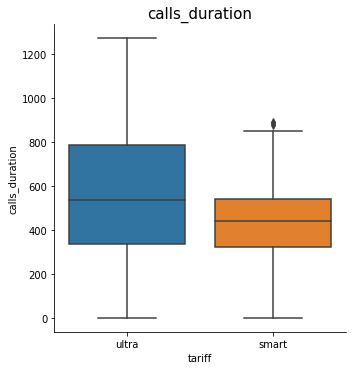

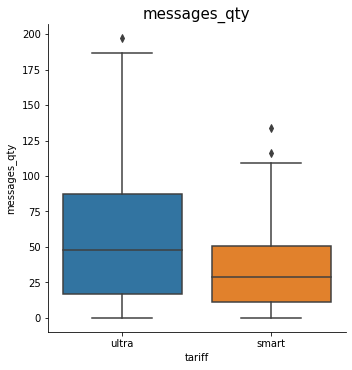

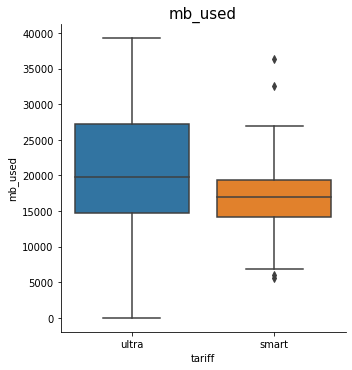

In [28]:
for column in ['calls_duration', 'messages_qty', 'mb_used']:
    sns.catplot(x='tariff', y=column, data=medians_per_month, kind='box')
    plt.title(column, fontsize=15)

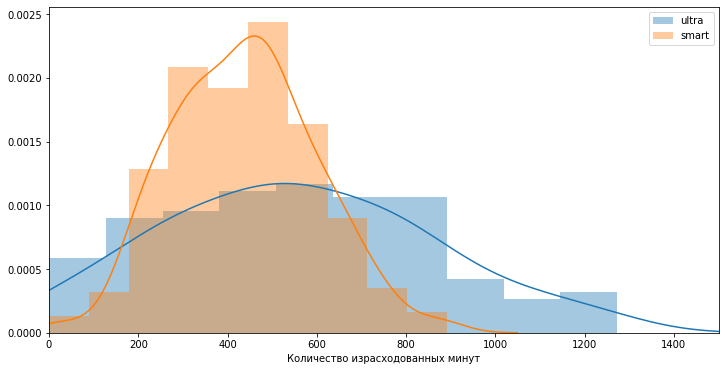

In [29]:
plt.figure(figsize=(12,6))
for tariff in ['ultra', 'smart']:
    sns.distplot(medians_per_month.query('tariff == @tariff')['calls_duration'], kde=True, bins=10)


plt.xlim(0,1500)
plt.xlabel('Количество израсходованных минут')
plt.legend(['ultra', 'smart'])
plt.show()

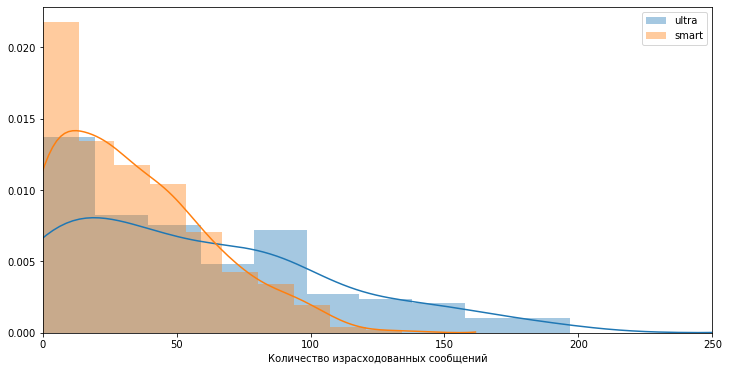

In [30]:
plt.figure(figsize=(12,6))
for tariff in ['ultra', 'smart']:
    sns.distplot(medians_per_month.query('tariff == @tariff')['messages_qty'], kde=True, bins=10)
    
plt.xlim(0,250)
plt.xlabel('Количество израсходованных сообщений')
plt.legend(['ultra', 'smart'])
plt.show()

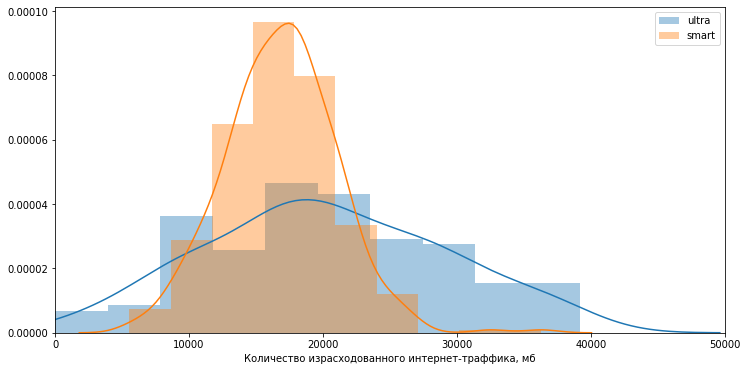

In [31]:
plt.figure(figsize=(12,6))
for tariff in ['ultra', 'smart']:
    sns.distplot(medians_per_month.query('tariff == @tariff')['mb_used'], kde=True, bins=10)
    
plt.xlim(0,50000)
plt.xlabel('Количество израсходованного интернет-траффика, мб')
plt.legend(['ultra', 'smart'])
plt.show()

Из графиков видно, что для тарифа 'ultra' дисперсии и размахи больше, медианы смещены в большую сторону в большей степени, чем для тарифа 'smart'. Выборка среди пользователей с тарифом 'ultra' содержит меньше выбросов.

Распределения минут и интернет-трафика близки к нормальному распределению и относительно симметричны. Такое распределение похоже на распределение Стьюдента.

Гистограмма распределения сообщений характеризует скошенный вправо датасет, что свидетельствует о том, что медиана меньше, чем среднее.

### Вывод

В результате анализа данных были получены данные, которые позволили нам описать поведение пользователей в зависимости от тарифа:
- в среднем пользователь тарифа 'smart' тратит 438 минут в месяц, а тарифа 'ultra' - 558 минут;
- в среднем пользователь тарифа 'smart' расходует 16.5 гб трафика, а тарифа 'ultra' - 20 гб;
- в среднем пользователь тарифа 'smart' отправляет 34 сообщения, а тарифа 'ultra' - 57;
- в среднем пользователи тарифа 'smart' укладываются в доступный лимит минут и сообщений, но им не хватает включённого интернет-трафика. Им приходится докупать 2 гб трафика, а это 400 руб. - достаточно много по сравнению с основной стоимостью тарифа (550 руб.);
- в среднем пользователи тарифа 'ultra' больше разговаривают по телефону, больше отправляют сообщений и больше тратят интернет-трафика. При этом в среднем пользователи не превышают доступные им лимиты в рамках тарифа.

Построенные графики показывают нам, что размах значений для пользователей тарифа 'ultra' шире, чем размах значений пользователей тарифа 'smart'. Также мы увидели, что в выборке пользователей с тарифом 'smart' много выбросов.

## Проверка гипотез

Нам необходимо проверить гипотезу о том, что выручки тарифов различаются.
Нулевая альтернативная гипотезы звучат так:
- H₀ - средняя выручка пользователей тарифов 'ultra' и 'smart' равна.
- H₁ - средняя выручка пользователей тарифов 'ultra' и 'smart' различается.

H₀ всегда формулируется так, чтобы использовать знак равенства.
Пороговое значение alpha равно 0.05.

In [32]:
ultra_users = total_data.query('tariff == "ultra"')['monthly_revenue']
smart_users = total_data.query('tariff == "smart"')['monthly_revenue']

alpha = 0.05

results = st.ttest_ind(
    ultra_users, 
    smart_users, 
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.7240946993530856e-246
Отвергаем нулевую гипотезу


In [33]:
total_data.pivot_table(index='tariff', values='monthly_revenue', aggfunc=['count', 'mean','median'])

,count,mean,median
,monthly_revenue,monthly_revenue,monthly_revenue
tariff,,,
smart,2229,1294.63930,1038
ultra,985,2071.06599,1950


Полученное значение p-value говорит о том, что средняя выручка от разных тарифов не равна. Мы отвергаем нулевую гипотезу и подтверждаем альтернативную гипотезу.
Чтобы её подтвердить, можно посмотреть среднее и медианное значения выручки в зависимости от тарифа. Как мы видим, они достаточно сильно различаются.

Нам необходимо проверить ещё одну гипотезу о том, что выручка пользователей из Москвы отличается от выручки пользователей из других регионов.
Нулевая альтернативная гипотезы звучат так:
- H₀ - средняя выручка пользователей из Москвы и из других регионов равна.
- H₁ - средняя выручка пользователей из Москвы и из других регионов различается.

H₀ всегда формулируется так, чтобы использовать знак равенства.
Пороговое значение alpha равно 0.05.

In [34]:
ultra_users = total_data.query('city == "Москва"')['monthly_revenue']
smart_users = total_data.query('city != "Москва"')['monthly_revenue']

alpha = 0.05

results = st.ttest_ind(
    ultra_users, 
    smart_users, 
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5126564657748214
Не получилось отвергнуть нулевую гипотезу


In [35]:
cities = total_data.copy()
cities.loc[cities.loc[:,'city'] != 'Москва', 'city'] = 'Другой город'

In [36]:
cities.pivot_table(index='city', values='monthly_revenue', aggfunc=['count', 'mean','median'])

,count,mean,median
,monthly_revenue,monthly_revenue,monthly_revenue
city,,,
Другой город,2603,1528.316942,1587
Москва,611,1550.805237,1750


Полученное значение p-value говорит о том, что средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов. Мы не отвергаем нулевую гипотезу.
Чтобы её подтвердить, можно посмотреть среднее и медианное значения выручки в зависимости от города. Как мы видим, они различаются не сильно.

### Вывод

В результате проверки двух гипотез можно сделать следующие выводы:

1) средняя выручка пользователей тарифов 'ultra' и 'smart' отличается, что подтверждается средним и медианным значениями.
Была отвергнута нулевая гипотеза и подтверждена альтернативная.

2) средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов, что подтверждается средним и медианным значениями. Была подтверждена нулевая гипотеза. 

Для оценки был использован уровень статистической значимости критерия Стьюдента для независимых выборок. В данном случае критерий задан значением 0.05.

## Общий вывод

В ходе данного исследования были сделаны следующие шаги:

1) предварительный анализ показал, что есть пропуски только в одном столбце 'churn_date'. В результате анализа их решено было не заполнять, т.к. наличие пропуска характеризует, что клиент ещё пользовался услугами оператора на момент выгрузки данных. Также были обнаружены нулевые значения в столбцах 'duration' и 'mb_used', которые свидетельствуют о пропущенных звонках и не тарифицируемых соединениях. 

2) на этапе предобработки данных были изменены типы данных в столбцах с датами, чтобы можно было выделить месяц. Значения в столбцах 'duration' и 'mb_used' были округлены вверх до целого числа (в соответствии с тарифами оператора) и поменяли тип данных на целочисленный. Далее были созданы групповые таблицы о совершенных действиях пользователей по месяцам.

3) в ходе анализа данных были сделаны следующие выводы:
 - в среднем пользователь тарифа 'smart' тратит 438 минут в месяц, а тарифа 'ultra' - 558 минут;
 - в среднем пользователь тарифа 'smart' расходует 16.5 гб трафика, а тарифа 'ultra' - 20 гб;
 - в среднем пользователь тарифа 'smart' отправляет 34 сообщения, а тарифа 'ultra' - 57;
 - в среднем пользователи тарифа 'smart' укладываются в доступный лимит минут и сообщений, но им не хватает включённого интернет-трафика. Им приходится докупать 2 гб трафика, а это 400 руб. - достаточно много по сравнению с основной стоимостью тарифа (550 руб.);
 - в среднем пользователи тарифа 'ultra' больше разговаривают по телефону, больше отправляют сообщений и больше тратят интернет-трафика. При этом в среднем пользователи не превышают доступные им лимиты в рамках тарифа.
 
4) Проводя статистический анализа мы проверили две гипотезы с уровнем значимости =0.05 :
 - средняя выручка пользователей тарифов 'ultra' и 'smart' отличается, что подтверждается средним и медианным значениями. Была отвергнута нулевая гипотеза и подтверждена альтернативная.
 - средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов, что подтверждается средним и медианным значениями. Была подтверждена нулевая гипотеза.
 - для оценки был использован уровень статистической значимости критерия Стьюдента для независимых выборок. 

Исходя из полученных данных, тариф 'ultra' выглядит для оператора лучше, т.к. средняя выручка выше более, чем в 1.5 раза. Но при этом количество пользователей более чем в 2 раза меньше, чем на тарифе 'smart'.
Оставив только один тариф, есть вероятность, что многие пользователи перейдут к конкурентам, т.к. не готовы к более высоким расходам по сравнению с текущим. Нужно соблюдать баланс и оставить пользователям выбирать тариф.